In [ ]:
import torch
import torchvision

print(torch.__version__) #want 1.12+
print(torchvision.__version__) #want 0.13+

2.3.0+cu121
0.18.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Get data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

#Set up data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"  #images from a subset of classes from Food101 dateset

#if the image folder doesn't exist we download it from the data from github and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists skipping download...")
else:
  print(f"Didn't find {image_path} downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  #Download pizza steak and sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading pizza_steak_sushi data...")
    f.write(request.content)

  #Unzip pizza_steak_sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping pizza_steak_sushi data...")
    zip_ref.extractall(image_path)

  #Remove zip file
  os.remove(data_path/ "pizza_steak_sushi.zip")

Didn't find data/pizza_steak_sushi downloading it...
downloading pizza_steak_sushi data...
unzipping pizza_steak_sushi data...


In [ ]:
#set up directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#2. Create datasets and Dataloaders

use 'data_setup.py' and 'create_dataloaders' func we made in 05

In [ ]:
from going_modular.going_modular import data_setup

#2.1 Creating a transform for 'torchvision.models' (MANUAL)
'torchvision.models' contains pretrained models -- free to use for transfer learning

In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), #get images into range [0,1]
    normalize  #images have same dist as ImageNet
])

In [ ]:
from going_modular.going_modular import data_setup
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ab7b574e5c0>,
 ['pizza', 'steak', 'sushi'])

#2.2 Automatic transform for 'torchvision.models'

In [ ]:
#Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  #DEFAULT = best available wights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
#Get transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#Create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = auto_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ab6d3557f70>,
 ['pizza', 'steak', 'sushi'])

#3. Getting a pretrained model
1. pytorch domain libraries
2. libraries like 'timm' (torch image models)
3. Hugging Face Hub (for plenty of different models)
4. Papers with code (for differnt preblem spaces/domains)

#3.1 #which pretrained model should you use?
exp

#3.2 Setting up a pretrained model
create an instance of pretrained EffNet_B0

In [ ]:
#Old way of creating a pretrained model
#model = torchvision.models.efficientnet_b0(pretrained=True)

#New method for creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

#3.3 Getting a summary of our model with torchinfo.summary()

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#Freezing the base layer and chaging the output layer to suit our need


In [ ]:
#Freeze all the base layer in EffNet_B0
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
len(class_names)

3

In [ ]:
#Update classifier head to suit our problem
from torch import nn

torch.manual_seed(42)

num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              ).to(device)
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

#4. Train model

In [ ]:
#Define an loss and an optimizer
loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [ ]:
#Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#start the timer
from timeit import default_timer as timer
start_time = timer()

#Train and save the result
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)



#end timer
end_time = timer()
print(f"Total time: {end_time - start_time:.3f}seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
Total time: 197.307seconds


#5. Evakuate model by  plotting loss curve

Try failed



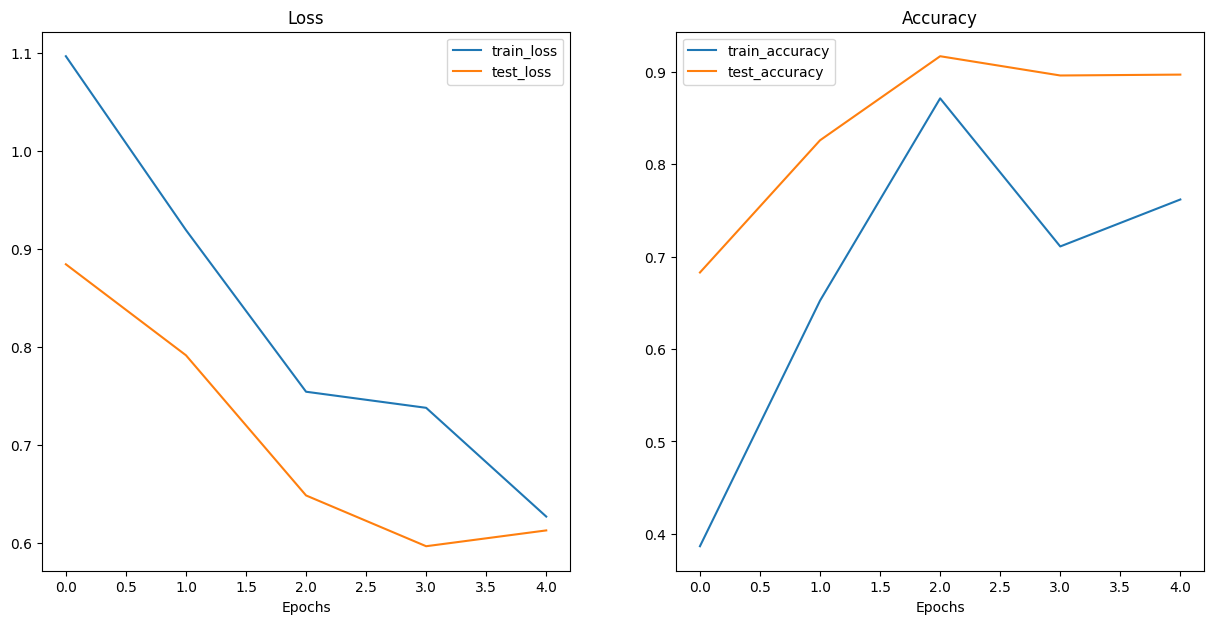

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print("Try failed\n")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

#plot
plot_loss_curves(results)

#6. Make prediction on images from test set

In [ ]:
from typing import List, Tuple, Dict

from PIL import Image
from torchvision import transforms

#Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names:List[str],
                        image_size: Tuple[int,int]=[224,224],
                        transform: torchvision.transforms= None,
                        device: torch.device=device):
  #2. Open the image with PIL
  img = Image.open(image_path)

  #3.Create a transform if doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  #4. predict on image
  model.to(device)
  model.eval()
  with torch.inference_mode():
    #convert image into tensor -- Transform the image and add an extra dim(batch size)
    transformed_image = image_transform(img).unsqueeze(dim=0)

    #Make a prediction on transformed image by passing it to model
    target_image_pred = model(transformed_image.to(device)) #output logits
    print(target_image_pred.max())
  #Convert the model's output to probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim =1)

  #Convert pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim =1)

  #plot the image with predicted label and prob
  plt.figure()
  plt.imshow(img)  #matplotlib will through err if we pass transformed image
  plt.title(f"Pred: {class_names[target_image_pred_label ]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

In [ ]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

tensor(0.0611)
tensor(1.5013)
tensor(0.9963)


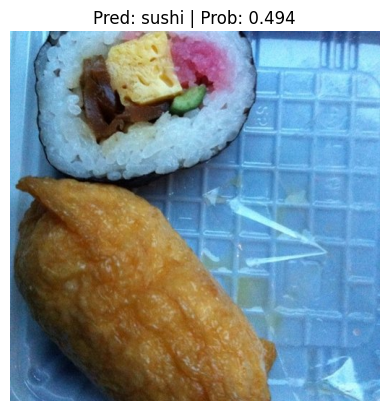

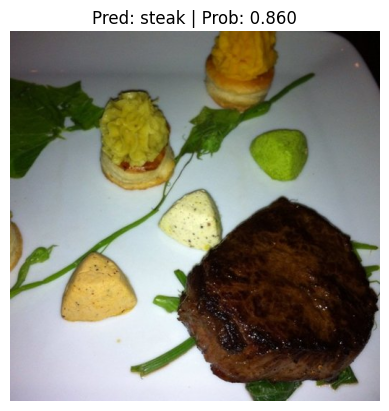

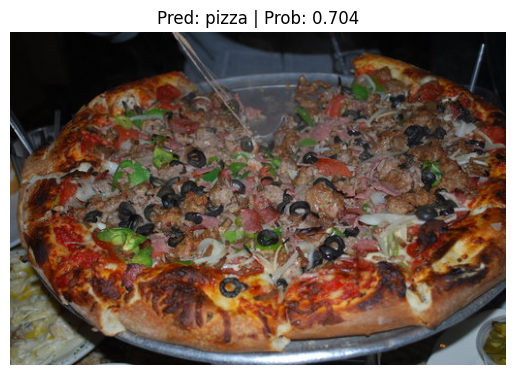

In [ ]:
#Get a random list of image paths from the test set
import random
num_images_to_plot =3
random_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
random_image_path_sample = random.sample(population=random_image_path_list, k=num_images_to_plot)

#random_image_path_sample
for image_path in random_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224),
                      )

#6.1Making prediction on your own custom data


In [ ]:
import requests

#setup custom image path
custom_image_path = data_path /"04-pizza-dad.jpeg"

#Download the image if not exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} Already exists...")

Download data/04-pizza-dad.jpeg...


tensor(0.2583)


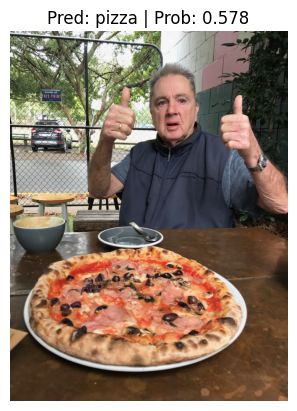

In [ ]:
pred_and_plot_image(model=model,
                      image_path=custom_image_path,
                      class_names=class_names,
                      )